# Real-Time Semantic Segmentation for Urban Street Video

## 1. Introducción

Este proyecto implementa un sistema de segmentación semántica para video de calles urbanas. La tarea requiere que el sistema procese video de dash-cam (en vivo o grabado), detecte y etiquete objetos clave de la carretera usando modelos pre-entrenados. La segmentacion semantica se puede decir un tipo de object detection, ya que se identifican objetos pero a nivel pixel



## 2. Dataset

Usamos el dataset **Mapillary Vistas**, muy parcido a Cityscapes , que contiene 25,000 imágenes de alta resolución con anotaciones precisas a nivel de píxel para 66 clases de objetos diferentes. Este dataset incluye escenas de diferentes ubicaciones geográficas, condiciones climáticas y momentos del día, lo que lo hace ideal para evaluar qué tan bien funciona el modelo en situaciones reales.

El dataset incluye clases importantes para conducción urbana como:
- Personas
- Vehículos (carros, camiones, autobuses, motocicletas)
- Ciclistas
- Señales de tránsito y semáforos




### Modelo Mask2Former

Para la segmentación semántica, usamos **Mask2Former** (Masked-attention Mask Transformer), que fue presentado en el paper ["Masked-attention Mask Transformer for Universal Image Segmentation"](https://arxiv.org/pdf/2112.01527) en 2021. Este modelo es capaz de hacer diferentes tipos de segmentación (panóptica, por instancias, o semántica) con la misma arquitectura, lo cual es muy útil. Sin embargo para este proyecto solo usamos segmentacion semantica

Este modelo fue entrenado con COCO. Según los resultados reportados en el paper, este modelo tiene los siguientes resultados:

| Método | Backbone | Epochs | PQ | AP | mIoU | Parámetros | FPS |
|--------|----------|--------|----|----|------|------------|-----|
| **Mask2Former** | Swin-L | 100 | **57.8** | **48.6** | **57.7** | 216M | 4.0 |

- **mIoU (mean Intersection over Union)**: 57.7 en segmentación semántica

### Modelo OneFormer

También utilizamos **OneFormer** (One Transformer to Rule Universal Image Segmentation), presentado en el paper ["OneFormer: One Transformer to Rule Universal Image Segmentation"](https://arxiv.org/pdf/2211.06220) en 2022. OneFormer es un framework universal de segmentación de imágenes que unifica la segmentación con un diseño multi-tarea de entrenamiento único ("train-once").

Según los resultados reportados en el paper, OneFormer con backbone Swin-L logra los siguientes resultados en ADE20K:

| Método | Backbone | Parámetros | PQ | AP | mIoU (s.s.) | mIoU (m.s.) |
|--------|----------|------------|----|----|-------------|-------------|
| **OneFormer** | Swin-L | 219M | **67.2** | **45.6** | 83.0 | **84.4** |

Notablemente, un solo modelo OneFormer supera a los modelos especializados Mask2Former en las tres tareas de segmentación en ADE20K, Cityscapes y COCO, a pesar de que Mask2Former fue entrenado individualmente en cada una de las tres tareas con tres veces los recursos. Para este proyecto, utilizamos OneFormer entrenado en COCO y lo aplicamos para segmentación semántica.







### Medir rendimiento y latencia
- **Latencia**: Tiempo que tarda en procesar cada frame (en milisegundos)
- **Throughput/FPS**: Cuántos frames por segundo puede procesar
- **Uso de memoria**: Cuánta memoria GPU/CPU se necesita

### Evaluación de precisión
- **mIoU**: Precisión de segmentación usando Intersection over Union
- **Precisión por clase**: Ver qué clases detecta bien y cuáles no


In [4]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
import torch
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import os
warnings.filterwarnings("ignore")

#### **Clases** ####

In [ ]:
#Loading classes
with open('config.json', 'r') as f:
    config = json.load(f)

labels = config['labels']
color_map = np.zeros((len(labels), 3), dtype=np.uint8)  # Predefined colormap
class_names = []
for idx, label in enumerate(labels):
    color_map[idx] = label['color']
    class_names.append(label['readable'])

In [3]:
for i, class_name in enumerate(class_names):
    print(i, class_name)

0 Bird
1 Ground Animal
2 Curb
3 Fence
4 Guard Rail
5 Barrier
6 Wall
7 Bike Lane
8 Crosswalk - Plain
9 Curb Cut
10 Parking
11 Pedestrian Area
12 Rail Track
13 Road
14 Service Lane
15 Sidewalk
16 Bridge
17 Building
18 Tunnel
19 Person
20 Bicyclist
21 Motorcyclist
22 Other Rider
23 Lane Marking - Crosswalk
24 Lane Marking - General
25 Mountain
26 Sand
27 Sky
28 Snow
29 Terrain
30 Vegetation
31 Water
32 Banner
33 Bench
34 Bike Rack
35 Billboard
36 Catch Basin
37 CCTV Camera
38 Fire Hydrant
39 Junction Box
40 Mailbox
41 Manhole
42 Phone Booth
43 Pothole
44 Street Light
45 Pole
46 Traffic Sign Frame
47 Utility Pole
48 Traffic Light
49 Traffic Sign (Back)
50 Traffic Sign (Front)
51 Trash Can
52 Bicycle
53 Boat
54 Bus
55 Car
56 Caravan
57 Motorcycle
58 On Rails
59 Other Vehicle
60 Trailer
61 Truck
62 Wheeled Slow
63 Car Mount
64 Ego Vehicle
65 Unlabeled


#### **Modelos** ####

In [7]:
mask2former_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic",use_fast=True)
mask2former_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")

In [8]:
oneformer_processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_coco_swin_large")
oneformer_model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large")

In [62]:

    # Crear mapeo: oneformer_label -> config_label_index
oneformer_to_config = {}
for config_idx, label in enumerate(labels):
    oneformer_label = label.get("oneformer_label")
    if oneformer_label is not None:
        oneformer_to_config[oneformer_label] = config_idx


In [63]:
# Funciones de predicción

def predict_with_mask2former(image_path, selected_classes=None, color_map=None):
    # Cargar imagen
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Preprocesar
    inputs = mask2former_processor(images=image, return_tensors="pt")
    
    # Inferencia
    with torch.no_grad():
        outputs = mask2former_model(**inputs)
    
    # Post-procesar
    predicted_semantic_map = mask2former_processor.post_process_semantic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]]
    )[0]
    semantic_map_array = predicted_semantic_map.cpu().numpy()
    
    # Aplicar colores a clases seleccionadas
    color_image = np.array(image)
    for class_idx in selected_classes:
        color_image[semantic_map_array == class_idx] = color_map[class_idx]
    
    return image, color_image, semantic_map_array


def predict_with_oneformer(image_path, selected_classes=None, color_map=None, oneformer_to_config=None):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Preprocesar (OneFormer requiere task_inputs)
    inputs = oneformer_processor(images=image, task_inputs=["semantic"], return_tensors="pt")
    # Inferencia
    with torch.no_grad():
        outputs = oneformer_model(**inputs)
    
    # Post-procesar
    predicted_semantic_map = oneformer_processor.post_process_semantic_segmentation(
        outputs, 
        target_sizes=[image.size[::-1]]
    )[0]
    semantic_map_array = predicted_semantic_map.cpu().numpy()
    
    # Aplicar colores a clases seleccionadas
    color_image = np.array(image)
    

    valid_oneformer_labels = [label for label in selected_classes if label is not None]
        
    # Aplicar colores solo para las clases seleccionadas
    for oneformer_label in [label for label in valid_oneformer_labels if label in oneformer_to_config]:
            config_idx = oneformer_to_config[oneformer_label]
            mask = semantic_map_array == oneformer_label
            if mask.any():  # Solo aplicar si hay píxeles que coinciden
                color_image[mask] = color_map[config_idx]

    return image, color_image, semantic_map_array

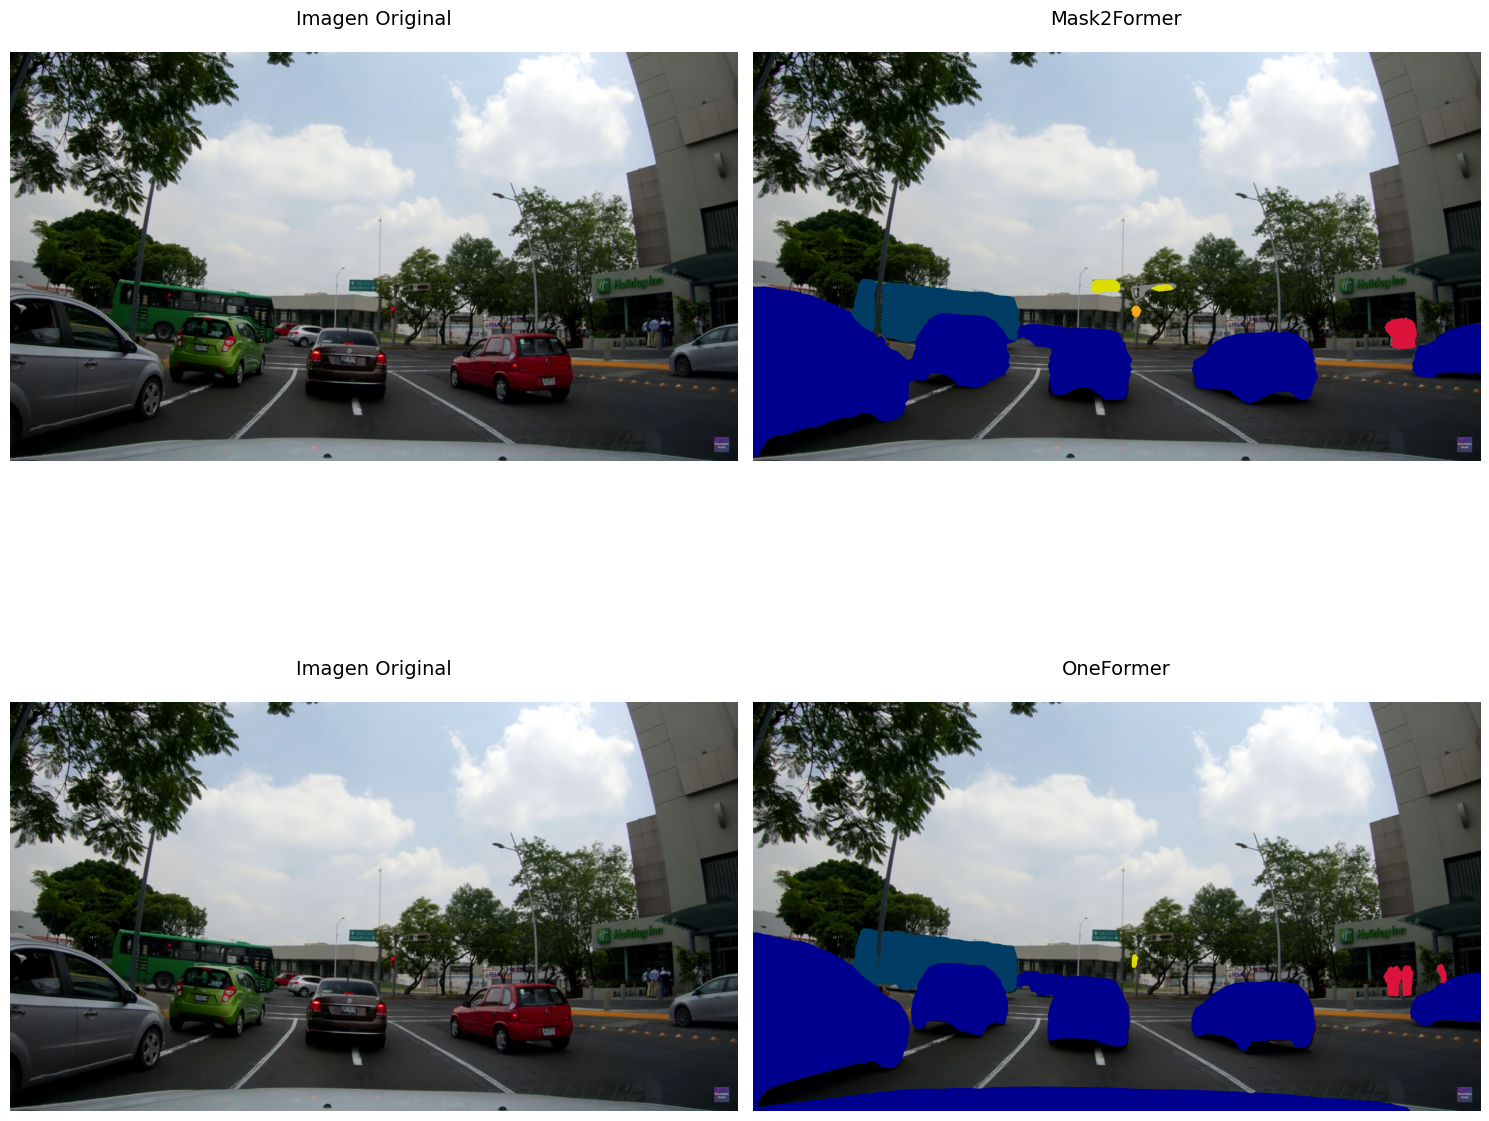

In [64]:
# Visualización comparativa con Mask2Former y OneFormer

image_path = 'data/images/example_image.png'

# Clases seleccionadas para resaltar
selected_classes = [19,20,46,48,49,50,52,54,55,61]  # Person, Bicyclist, Traffic Sign Frame, Traffic Light, Traffic Signs, Bicycle, Bus, Car, Truck

# Realizar predicciones con ambas funciones
image_original, mask2former_color_image, mask2former_array = predict_with_mask2former(
    image_path, 
    selected_classes=selected_classes, 
    color_map=color_map
)

_, oneformer_color_image, oneformer_array = predict_with_oneformer(
    image_path, 
    selected_classes=[v.get("oneformer_label") for i, v  in enumerate(config['labels']) if i in selected_classes], 
    color_map=color_map,
    oneformer_to_config=oneformer_to_config
)

# Visualización 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Fila 1: Original y Mask2Former
axes[0, 0].imshow(image_original)
axes[0, 0].set_title("Imagen Original", fontsize=14, pad=20)
axes[0, 0].axis("off")

axes[0, 1].imshow(mask2former_color_image)
axes[0, 1].set_title("Mask2Former", fontsize=14, pad=20)
axes[0, 1].axis("off")

# Fila 2: Original y OneFormer
axes[1, 0].imshow(image_original)
axes[1, 0].set_title("Imagen Original", fontsize=14, pad=20)
axes[1, 0].axis("off")

axes[1, 1].imshow(oneformer_color_image)
axes[1, 1].set_title("OneFormer", fontsize=14, pad=20)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


In [71]:
# Video Semantic Segmentation Functions

def resize_frame(frame, max_width=1280, max_height=720):
    """
    Resize a frame to reduce video size while maintaining aspect ratio.
    
    Args:
        frame: Input frame (numpy array)
        max_width: Maximum width for the resized frame (default: 1280)
        max_height: Maximum height for the resized frame (default: 720)
    
    Returns:
        resized_frame: Resized frame maintaining aspect ratio
        new_width: New width of the frame
        new_height: New height of the frame
    """
    height, width = frame.shape[:2]
    
    # Calculate scaling factor to fit within max dimensions
    scale = min(max_width / width, max_height / height)
    
    # Only resize if the frame is larger than max dimensions
    if scale < 1.0:
        new_width = int(width * scale)
        new_height = int(height * scale)
        resized_frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return resized_frame, new_width, new_height
    else:
        return frame, width, height


def process_video_with_mask2former(video_path, selected_classes=None, color_map=None, max_width=640, max_height=360):
    """
    Process a video with Mask2Former semantic segmentation and save the output.
    
    Args:
        video_path: Path to input video file (e.g., 'input1.mov')
        selected_classes: List of class indices to highlight
        color_map: Color mapping array (uses global if not provided)
        max_width: Maximum width for resizing (default: 1280)
        max_height: Maximum height for resizing (default: 720)
    
    Returns:
        output_path: Path to the output video (e.g., 'input1_mask2former.mp4')
    """
    # Generate output path: input1.mov -> input1_mask2former.mp4
    base_path = os.path.splitext(video_path)[0]
    output_path = f"{base_path}_mask2former.mp4"
    
    # Use global color_map if not provided
    if color_map is None:
        color_map = globals().get('color_map')
        if color_map is None:
            raise ValueError("color_map must be provided or defined globally")
    
    # Default selected classes if not provided
    if selected_classes is None:
        selected_classes = [19, 20, 46, 48, 49, 50, 52, 54, 55, 61]
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Original video properties: {width}x{height}, {fps} fps, {total_frames} frames")
    
    # Read first frame to determine resized dimensions
    ret, first_frame = cap.read()
    if not ret:
        cap.release()
        raise ValueError("Could not read first frame from video")
    
    # Resize first frame to determine output dimensions
    resized_first, new_width, new_height = resize_frame(first_frame, max_width, max_height)
    print(f"Resized video dimensions: {new_width}x{new_height}")
    print(f"Processing with Mask2Former...")
    
    # Reset video to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # Define codec and create VideoWriter with resized dimensions
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    frame_count = 0
    
    # Process video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if frame_count % 10 == 0:  # Progress indicator
            print(f"Processing frame {frame_count}/{total_frames} ({100*frame_count/total_frames:.1f}%)")
        
        # Resize frame to reduce size
        frame, _, _ = resize_frame(frame, max_width, max_height)
        
        # Convert BGR to RGB (OpenCV uses BGR, PIL uses RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        image = Image.fromarray(frame_rgb)
        
        # Process with Mask2Former
        inputs = mask2former_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = mask2former_model(**inputs)
        predicted_semantic_map = mask2former_processor.post_process_semantic_segmentation(
            outputs, 
            target_sizes=[image.size[::-1]]
        )[0]
        semantic_map_array = predicted_semantic_map.cpu().numpy()
        
        # Create colored output
        color_frame = frame_rgb.copy()
        # Apply the colormap to selected classes
        for class_idx in selected_classes:
            color_frame[semantic_map_array == class_idx] = color_map[class_idx]
        
        # Convert RGB back to BGR for OpenCV
        color_frame_bgr = cv2.cvtColor(color_frame, cv2.COLOR_RGB2BGR)
        
        # Write frame to output video
        out.write(color_frame_bgr)
    
    # Release everything
    cap.release()
    out.release()
    
    print(f"Video processing complete! Output saved to: {output_path}")
    return output_path


def process_video_with_oneformer(video_path, selected_classes=None, color_map=None, oneformer_to_config=None, max_width=640, max_height=360):
    """
    Process a video with OneFormer semantic segmentation and save the output.
    
    Args:
        video_path: Path to input video file (e.g., 'input1.mov')
        selected_classes: List of class indices to highlight (config indices)
        color_map: Color mapping array (uses global if not provided)
        oneformer_to_config: Mapping from OneFormer labels to config indices (uses global if not provided)
        max_width: Maximum width for resizing (default: 1280)
        max_height: Maximum height for resizing (default: 720)
    
    Returns:
        output_path: Path to the output video (e.g., 'input1_oneformer.mp4')
    """
    # Generate output path: input1.mov -> input1_oneformer.mp4
    base_path = os.path.splitext(video_path)[0]
    output_path = f"{base_path}_oneformer.mp4"
    
    # Use global color_map if not provided
    if color_map is None:
        color_map = globals().get('color_map')
        if color_map is None:
            raise ValueError("color_map must be provided or defined globally")
    
    # Default selected classes if not provided
    if selected_classes is None:
        selected_classes = [19, 20, 46, 48, 49, 50, 52, 54, 55, 61]
    
    # Use global oneformer_to_config if not provided
    if oneformer_to_config is None:
        oneformer_to_config = globals().get('oneformer_to_config')
        if oneformer_to_config is None:
            raise ValueError("oneformer_to_config must be provided or defined globally")
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Original video properties: {width}x{height}, {fps} fps, {total_frames} frames")
    
    # Read first frame to determine resized dimensions
    ret, first_frame = cap.read()
    if not ret:
        cap.release()
        raise ValueError("Could not read first frame from video")
    
    # Resize first frame to determine output dimensions
    resized_first, new_width, new_height = resize_frame(first_frame, max_width, max_height)
    print(f"Resized video dimensions: {new_width}x{new_height}")
    print(f"Processing with OneFormer...")
    
    # Reset video to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # Define codec and create VideoWriter with resized dimensions
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(output_path, fourcc, fps, (new_width, new_height))
    
    frame_count = 0
    
    # Process video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        if frame_count % 10 == 0:  # Progress indicator
            print(f"Processing frame {frame_count}/{total_frames} ({100*frame_count/total_frames:.1f}%)")
        
        # Resize frame to reduce size
        frame, _, _ = resize_frame(frame, max_width, max_height)
        
        # Convert BGR to RGB (OpenCV uses BGR, PIL uses RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        image = Image.fromarray(frame_rgb)
        
        # Process with OneFormer
        inputs = oneformer_processor(images=image, task_inputs=["semantic"], return_tensors="pt")
        with torch.no_grad():
            outputs = oneformer_model(**inputs)
        predicted_semantic_map = oneformer_processor.post_process_semantic_segmentation(
            outputs, 
            target_sizes=[image.size[::-1]]
        )[0]
        semantic_map_array = predicted_semantic_map.cpu().numpy()
        
        # Create colored output
        color_frame = frame_rgb.copy()
        
        # Convert selected_classes (config indices) to OneFormer label indices
        oneformer_selected = [labels[i].get("oneformer_label") 
                             for i in selected_classes 
                             if i < len(labels) and labels[i].get("oneformer_label") is not None]
        valid_oneformer_labels = [label for label in oneformer_selected if label is not None]
        
        # Apply colors
        for oneformer_label in valid_oneformer_labels:
            if oneformer_label in oneformer_to_config:
                config_idx = oneformer_to_config[oneformer_label]
                mask = semantic_map_array == oneformer_label
                if mask.any():
                    color_frame[mask] = color_map[config_idx]
        
        # Convert RGB back to BGR for OpenCV
        color_frame_bgr = cv2.cvtColor(color_frame, cv2.COLOR_RGB2BGR)
        
        # Write frame to output video
        out.write(color_frame_bgr)
    
    # Release everything
    cap.release()
    out.release()
    
    print(f"Video processing complete! Output saved to: {output_path}")
    return output_path


In [ ]:
#Processing all videos
of1 = process_video_with_oneformer('data/videos/input2.mov')
m2f1 = process_video_with_mask2former('data/videos/input2.mov')

of2 = process_video_with_oneformer('data/videos/input3.mov')
m2f2 = process_video_with_mask2former('data/videos/input3.mov')

of3 = process_video_with_oneformer('data/videos/input4.mov')
m2f3 = process_video_with_mask2former('data/videos/input4.mov')

In [73]:
def display_videos_side_by_side(video1_path, video2_path, title1="Mask2Former", title2="OneFormer", width=640):
    """
    Display two videos side by side in a Jupyter notebook.
    
    Args:
        video1_path: Path to the first video (left side)
        video2_path: Path to the second video (right side)
        title1: Title for the first video (default: "Mask2Former")
        title2: Title for the second video (default: "OneFormer")
        width: Width of each video in pixels (default: 640)
    """
    from IPython.display import HTML, display
    
    html_content = f"""
    <div style="display: flex; gap: 20px; justify-content: center; align-items: flex-start;">
        <div style="text-align: center;">
            <h3>{title1}</h3>
            <video width="{width}" controls>
                <source src="{video1_path}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
        </div>
        <div style="text-align: center;">
            <h3>{title2}</h3>
            <video width="{width}" controls>
                <source src="{video2_path}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
        </div>
    </div>
    """
    
    display(HTML(html_content))

In [ ]:
display_videos_side_by_side(m2f1, of1)

In [ ]:
display_videos_side_by_side(m2f2, of2)


In [ ]:
display_videos_side_by_side(m2f3, of3)